# evaluate_optimal_CNN
- Having run optimised CNN for 35 epochs, taking a look at the training history (loss saved after every epoch, full model state saved after every 5) to determine best point to stop training (and hence return best model). 
- Loss history plot
- Regression plots

In [1]:
import keras 
import numpy as np
from sklearn import model_selection
import sdss_model_evaluate
from scipy import stats
import pandas as pd 

import harry_plotter
from matplotlib import rcParams
harry_plotter.default(rcParams)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

In [2]:
outpath = '../../plots/'

### Creating model history graph

In [3]:
tab = pd.read_csv('../final-model/training-history.csv')
tab.head(5)

,Unnamed: 0,loss,val_loss,lr
0,0,0.079526,0.034139,0.001
1,1,0.033100,0.029350,0.001
2,2,0.032883,0.028231,0.001
3,3,0.030773,0.027216,0.001
4,4,0.030431,0.043267,0.001


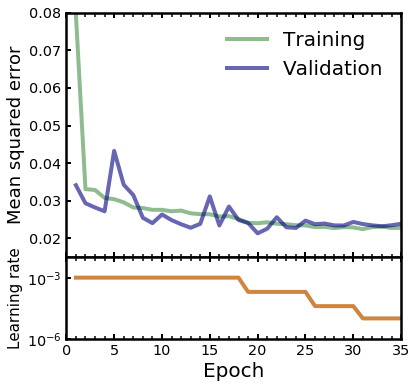

In [4]:
fig, ax = plt.subplots(2, figsize=(6, 6), sharex=True, 
                       gridspec_kw={'height_ratios': [3, 1]})

epochs = np.linspace(1, 35, 35)

# plotting loss in top row.
ax[0].plot(epochs, tab.loss.values, color='darkseagreen', label='Training', lw=4)
ax[0].plot(epochs, tab.val_loss.values, color='navy', label='Validation', lw=4, alpha=0.6)
ax[0].legend(frameon=False, fontsize=20)

ax[0].set_xlim([0, 35])
ax[0].set_ylim([0.015, 0.08])
ax[0].set_ylabel('Mean squared error', fontsize=18)

# plotting learning rate in bottom row.
ax[1].plot(epochs, tab.lr.values, color='peru', label='Learning Rate', lw=4)
ax[1].set_yscale('log')
ax[1].set_ylabel('Learning rate', fontsize=15)
ax[1].set_xlabel('Epoch', fontsize=20)
ax[1].set_ylim([10**-6, 10**-2])
harry_plotter.xtick_format(5, 1, ax=ax[0])
fig.subplots_adjust(hspace=0)
plt.savefig(outpath + 'loss_history.png', format='png', dpi=200, bbox_inches='tight')

### Evaluating set of model states (saved at epochs with 5 intervals)

In [5]:
data_dir = '../../data/cleaned_datasets/'

X_train = np.load(data_dir + 'X_train.npy')
X_val = np.load(data_dir + 'X_val.npy')
X_test = np.load(data_dir + 'X_test.npy')

y_train = np.load(data_dir + 'y_train.npy')
y_val = np.load(data_dir + 'y_val.npy')
y_test = np.load(data_dir + 'y_test.npy')

### Evaluating last 4 (epochs 20, 25, 30, 35) saved model states.

In [12]:
def plot_model_state(path, color, ax, label):
    model = keras.models.load_model(path)
    y_predicted = model.predict(X_test).ravel()
    sdss_model_evaluate.plot_regression(y_test, y_predicted, scatter=False, 
                                        color=color, ax=ax, label=label)
    print(file + ' test loss=' + str(model.evaluate(X_test, y_test)))
    print(stats.pearsonr(y_test, y_predicted))
    print(stats.spearmanr(y_test, y_predicted))
    return

31/31 [==============================] - 4s 144ms/step - loss: 0.0230
../final-model/saved-model-20-0.02.hdf5 test loss=0.02300930954515934
(0.7485191445913757, 3.513487844169369e-174)
SpearmanrResult(correlation=0.7586456523541126, pvalue=1.3968543950240473e-181)
31/31 [==============================] - 4s 144ms/step - loss: 0.0246
../final-model/saved-model-35-0.02.hdf5 test loss=0.024622641503810883
(0.7458508189220532, 2.7351218212984886e-172)
SpearmanrResult(correlation=0.7578198157643313, pvalue=5.785456289086149e-181)
31/31 [==============================] - 4s 145ms/step - loss: 0.0251
../final-model/saved-model-30-0.02.hdf5 test loss=0.025070292875170708
(0.7453767294926398, 5.895491750351239e-172)
SpearmanrResult(correlation=0.7573789551294776, pvalue=1.2325290556554328e-180)
31/31 [==============================] - 5s 148ms/step - loss: 0.0252
../final-model/saved-model-25-0.02.hdf5 test loss=0.0252145417034626
(0.7479576491234614, 8.824553942331672e-174)
SpearmanrResult(cor

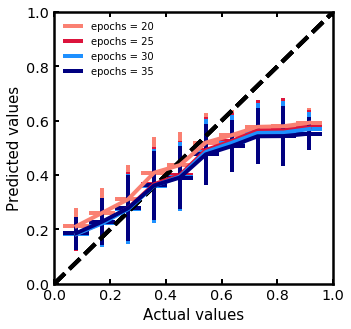

In [13]:
# selecting only those with loss 0.02
path = '../final-model/'

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
colors = ['salmon', 'crimson', 'dodgerblue', 'navy']
labels = ['epochs = 20', 'epochs = 25', 'epochs = 30', 'epochs = 35']

for ind, file in enumerate(glob.glob(path + '*02.hdf5')):
    plot_model_state(path+file, color=colors[ind], ax=ax, label=labels[ind])

ax.legend(frameon=False)
plt.savefig(outpath + 'epoch_comparison.png', format='png', dpi=200, bbox_inches='tight')

### Selecting model after 35 epochs to be final model
- There is minimial difference between (average) predictions of model after saved model states (20-35 epochs).
- Loss is slightly higher after 35 (relative to 20), however model has stabilised into potential minimum (as we can see in loss history)
- Evaluating using pearson statistic (to test linear correlation) shows very little difference in performance.
- Same story using spearman rank correlation coefficient.

### Creating final model evaluation plots
- creating binned statistic correlation plot (with scatter of raw data).

In [18]:
final_model = keras.models.load_model('../final-model/saved-model-35-0.02.hdf5')
y_predicted = final_model.predict(X_test).ravel()

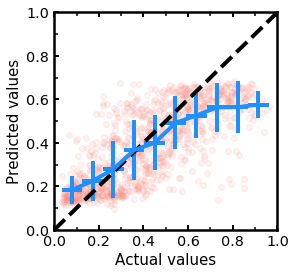

In [30]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sdss_model_evaluate.plot_regression(y_test, y_predicted, scatter=True, ax=ax)
harry_plotter.xtick_format(0.2, 0.1, ax=ax, format='%1.1f')
harry_plotter.ytick_format(0.2, 0.1, ax=ax, format='%1.1f')
plt.savefig(outpath + 'final_model_regression.png', format='png', dpi=200, bbox_inches='tight')